In [1]:
import numpy as np # library for data structures, vectors, matrices and mathematical functions
import matplotlib.pyplot as plt                   # library for plotting and visual representation
import matplotlib.transforms as transform                   # library for plotting and visual representation
from matplotlib import rcParams                   # module handling generic plot parameters
from matplotlib.ticker import (FormatStrFormatter)# module for figure axis formatting
import pandas as pd                               # data administration, here used for data import
from scipy.optimize import curve_fit              # fitting algorithm from the scipy package
from scipy.signal import find_peaks
from scipy.special import fresnel
from IPython.display import display as dy, Markdown as md, Latex as Lx, Image as Im, HTML as hm # displaying LaTeX code in code cells
import sympy as sp
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 15,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'figure.figsize': (10,6),
                    })

plt.rcParams['axes.facecolor'] = 'black' 
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['xtick.labelcolor'] = 'white'
plt.rcParams['ytick.labelcolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['grid.color'] = '#707070'
plt.rcParams['axes.titlepad'] = 20
legendfontsize=12

ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = { 'pdf', 'png'}

# Diffraction

Group #13

NG Kuok Fung | #3797903 

Edgar Harutyunyan | #3775171

**Overview of Tasks**

***Task 0***

Analytically calculate the Fourier transform of a single-slit and a double-slit function and compare these with the familiar Fraunhofer diffraction-patterns for these objects. Using FFT (Fast-Fourier-Transform), determine the Fourier transforms of the functions $F(k) = sinc(2\pi k) = sin(2\pi k)/(2\pi k)$ and $F^2(k)$. Discuss this result in the light of the convolution theorem.

***Task 1***

Measure the diffraction pattern of a single-slit in the Fraunhofer regime, and for three distances between slit and camera in the Fresnel regime.

In the Fraunhofer regime, determine the slit width $b$
    
    (a) from the position of the minima for various diffraction orders
    
    (b) from the FFT of the intensity profile.
    
In the Fresnel regime,
    
    (c) compare the measured diffraction patterns with the theory.


***Task 2***

Measure the diffraction pattern of a double-slit in the Fraunhofer regime, and for three distances between slit and camera in the Fresnel regime.
In the Fraunhofer regime, determine
    
    (a) the slit distance g from the position of the minima for various diffraction orders
    
    (b) the slit distance g and the slit width b from the fit of the Fraunhofer diffraction-pattern to the data
    
    (c) the slit distance g and the slit width b from the FFT of the intensity profile.

In the Fresnel regime,
    
    (d) compare the measured diffraction patterns with the theory.

In [2]:
# GLOBALS
data_dir = './data/'
Lambda = 635e-9 # m
f = 300.8e-3 # m
ds_g_th = 0.25e-3 # m double-slit given g
ds_b_a_th = 0.1e-3 # m double-slit given b_a
ds_b_b_th = 0.15e-3 # m double-slit given b_b
pw = 7e-6 # m pixel width
cp = 34 # mm camera position
z1 = (422 - cp) * 1e-3 # m
z2 = (337 - cp) * 1e-3 # m
z3 = (460 - cp) * 1e-3 # m
z_l = [z1, z2, z3]

def fit_and_plot(x,y, xlabel, ylabel, title, fit_func):
    plt.scatter(x, y, color='#ADD8E6',marker='x', label=r'Data')
    #plt.scatter(df[x_col], df[y_col], color=color,marker='x', label=f'{ylabel[:-4]} vs {xlabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    # Perform non-linear regression using curve_fit
    params, cov_mat = curve_fit(fit_func, x, y)
    
    # Plot the fitted curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, *params)
    plt.plot(x_fit, y_fit, color='red', label='Fitted Curve')
    plt.legend()
    plt.show()
    return [params, cov_mat]

## Task 0

***Task Definition***

Analytically calculate the Fourier transform of a single-slit and a double-slit function and compare these with the familiar Fraunhofer diffraction-patterns for these objects. Using FFT (Fast-Fourier-Transform), determine the Fourier transforms of the functions $F(k) = sinc(2\pi k) = sin(2\pi k)/(2\pi k)$ and $F^2(k)$. Discuss this result in the light of the convolution theorem.

## Task 1

***Task Definition*** 

Measure the diffraction pattern of a single-slit in the Fraunhofer regime, and for three distances between slit and camera in the Fresnel regime.

In the Fraunhofer regime, determine the slit width $b$
    
    (a) from the position of the minima for various diffraction orders
    
    (b) from the FFT of the intensity profile.
    
In the Fresnel regime,
    
    (c) compare the measured diffraction patterns with the theory.



### Task 1 a

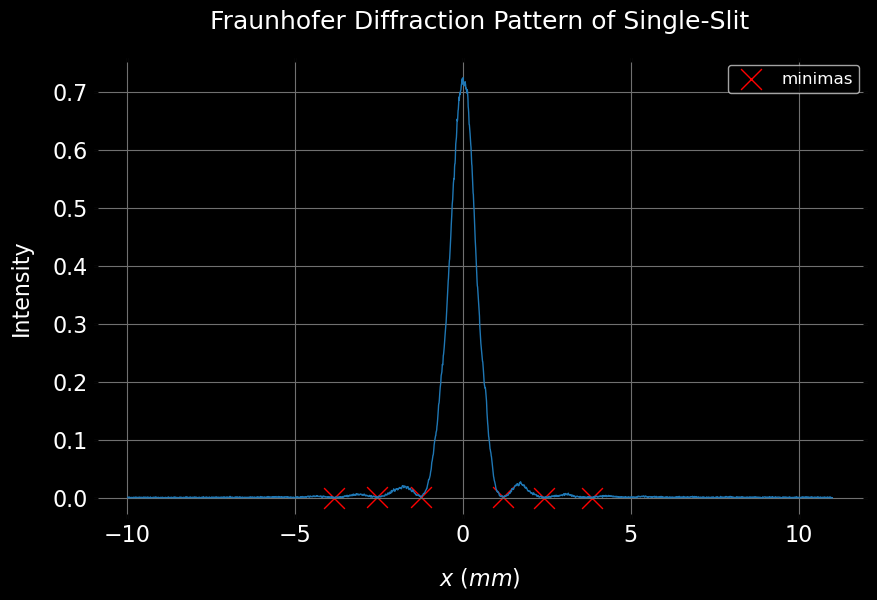

<IPython.core.display.Latex object>

In [3]:
file_path = data_dir + 'Task1_ab/SS_Fr_469_91_A.csv'

df = pd.read_csv(file_path, names=['x', 'I'])

x = np.array(df['x'], dtype=int)*pw # m
I = np.array(df['I'])
x = x - x[I.argmax()] # shift x to the max intensity

minima_indices, _ = find_peaks(-I, height=-0.01, distance=100, prominence=0.0032)
plt.plot(x*1e3, I)
plt.scatter(x[minima_indices]*1e3, I[minima_indices], marker='x', label = 'minimas', color = 'r')
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Fraunhofer Diffraction Pattern of Single-Slit')
plt.legend()
plt.show()
dy(Lx(r'$Figure\, 1.1$: Fraunhofer Diffraction Pattern of Single-Slit.'))

$$x_n \approx f\frac{n\lambda}{b}$$

$$ k \equiv \frac{f\lambda}{b}$$

$$b = \frac{f\lambda}{k}$$

$$\mu_b = \left|\frac{\partial b}{\partial k}\right|\mu_k = \left|-\frac{b}{k}\right|\mu_k$$

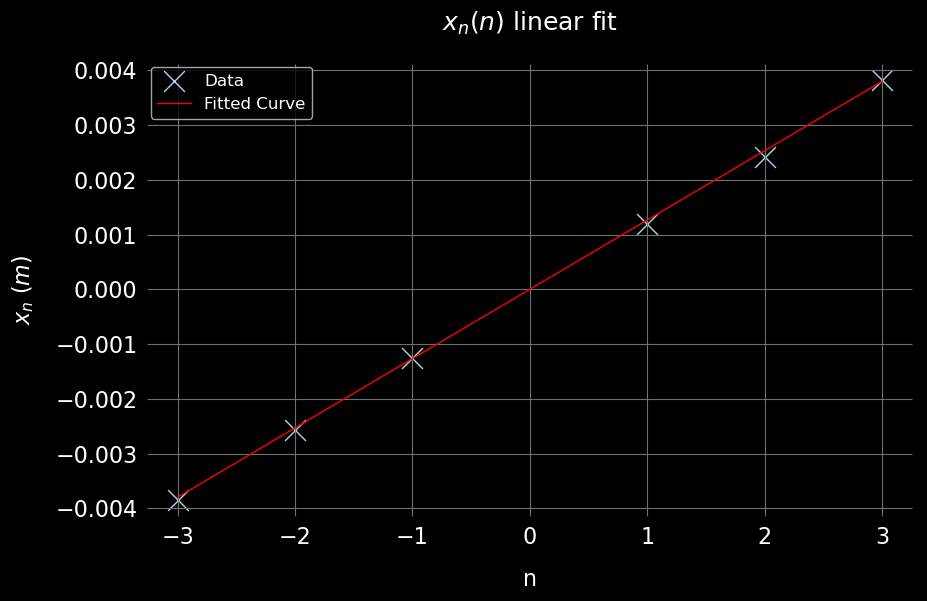

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
x_mins = x[minima_indices]
n = np.array(range(1, len(x_mins)//2+1))
n = np.sort(np.concatenate((-n, n))) # ordered symmetric list of orders e.g.: -3, -2, -1, 1, 2, 3

def y_x(x_arg, k_arg):
    return k_arg*x_arg
    
k, u_k_squared = fit_and_plot(n, x_mins, 'n', r'$x_n$ ($m$)', '$x_n(n)$ linear fit',  y_x)
dy(Lx(r'$Figure\, 1.2$: Linear fit of position with respect to minimum diffraction order.'))
ss_b_from_position = f*Lambda / k # single-slit b from position of minima
u_ss_b_from_position = ss_b_from_position / k * np.sqrt(u_k_squared)
dy(Lx(r'$$b = (%.2f \pm %.3f) ~mm $$' % (ss_b_from_position*1e3,u_ss_b_from_position*1e3)))

### Task1 b

$$k_x = \frac{2\pi}{\lambda}\frac{x}{\sqrt{x^2 + f^2}}$$

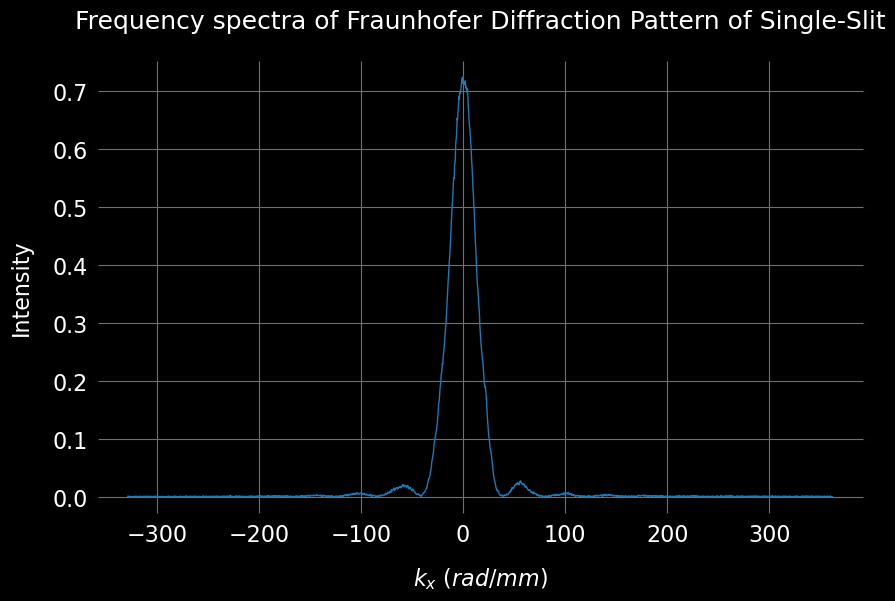

<IPython.core.display.Latex object>

In [5]:
k = 2*np.pi / Lambda * x / np.sqrt(x**2 + f**2)
#k = 2*np.pi / Lambda * x / f
plt.plot(k*1e-3, I)
plt.xlabel(r'$k_x$ ($rad/mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Frequency spectra of Fraunhofer Diffraction Pattern of Single-Slit')
#plt.legend()
plt.show()
dy(Lx(r'$Figure\, 1.3$: Frequency spectra of Fraunhofer Diffraction Pattern of Single-Slit.'))

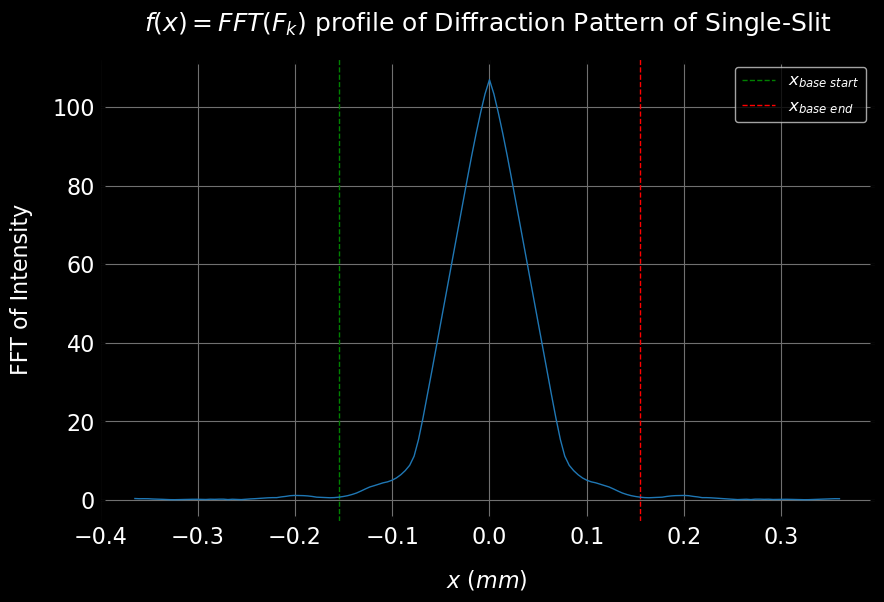

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [6]:
#F_k_fft = np.fft.ifft(I)
F_th = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(1.2*np.sinc(k*ss_b_from_position/np.pi)**2)))
F_k_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(I)))
freq = np.fft.fftshift(np.fft.fftfreq(len(k), d=np.gradient(k)/np.pi))
#plt.plot(freq*1e3, np.abs(F_k_fft))
F_k = np.abs(F_k_fft)
base_indices = (len(freq)//2-35) + np.where(F_k[len(freq)//2-35:len(freq)//2+35] > 0.7)[0]

# First and last indices of the base
base_start_index = base_indices[0]
base_end_index = base_indices[-1]
plt.axvline(freq[base_start_index]*1e3, color='g', linestyle='--', label=r'$x_{base~start}$')
plt.axvline(freq[base_end_index]*1e3, color='r', linestyle='--', label=r'$x_{base~end}$')
plt.plot(freq[len(freq)//2-80:len(freq)//2+80]*1e3, F_k[len(freq)//2-80:len(freq)//2+80])
#plt.plot(freq[len(freq)//2-80:len(freq)//2+80]*1e3, np.abs(F_th)[len(freq)//2-80:len(freq)//2+80])
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'FFT of Intensity')
plt.grid(True)
plt.legend()
plt.title(r'$f(x) = FFT(F_k)$ profile of Diffraction Pattern of Single-Slit')
plt.show()
dy(Lx(r'$Figure\, 1.4$: Fourier transformed profile of intensity of Single-Slit.'))
ss_b_from_base = 0.5*(freq[base_end_index] - freq[base_start_index])
dy(Lx(r'$$b = \frac{x_{base~end} - x_{base~start}}{2} \approx %.2f ~mm $$' % (ss_b_from_base*1e3)))

### Task1 c

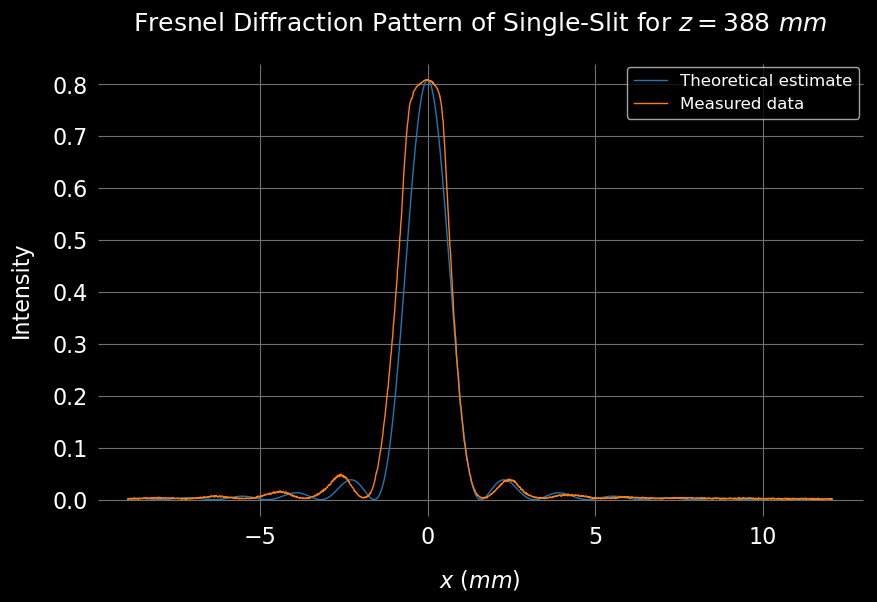

<IPython.core.display.Latex object>

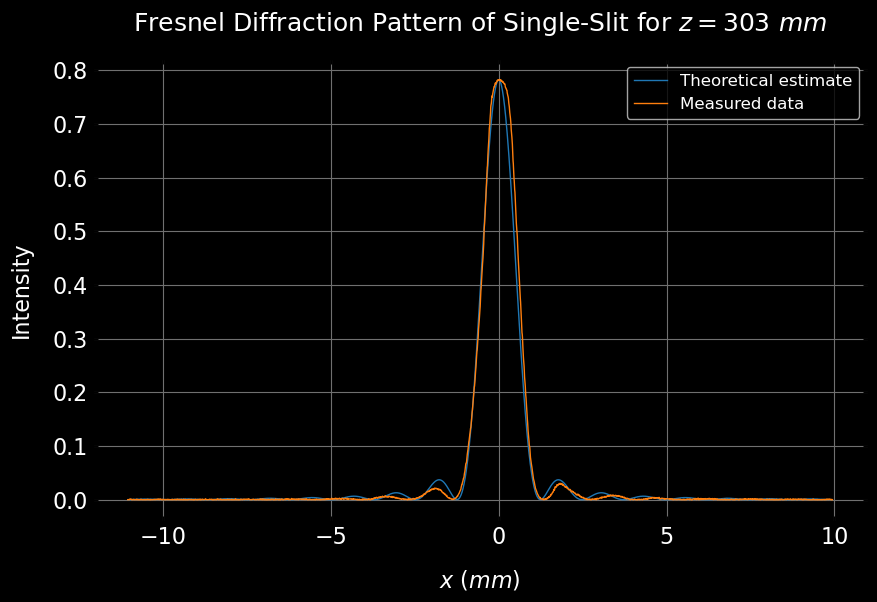

<IPython.core.display.Latex object>

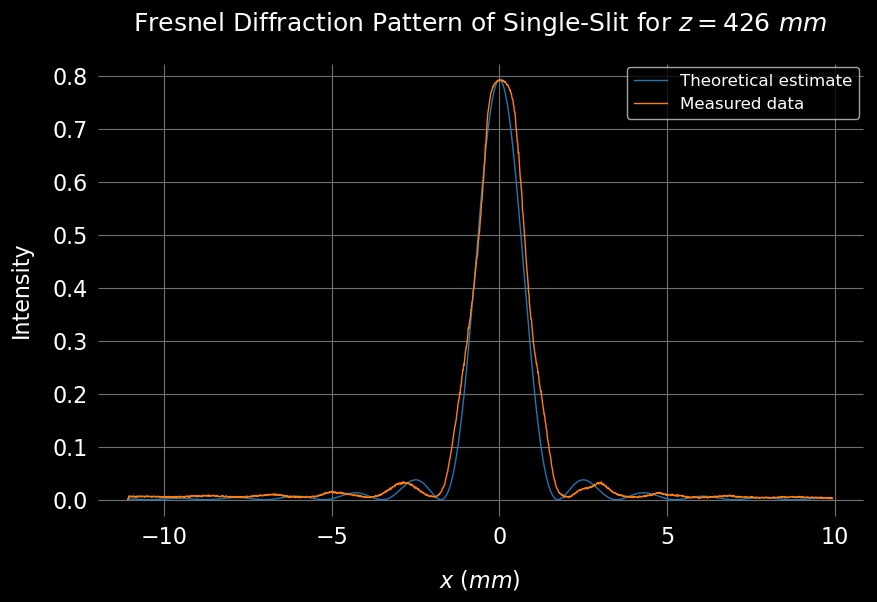

<IPython.core.display.Latex object>

In [7]:
task_dir = data_dir + 'Task1_c'
df_l = []
for path in os.listdir(task_dir):
    file_path = os.path.join(task_dir,path)
    if os.path.isfile(file_path): 
        df = pd.read_csv(file_path, names=['x', 'I'])
        x = np.array(df['x']) * pw 
        I = np.array(df['I'])
        x = x - x[I.argmax()]
        df_l.append(tuple([x,I]))
        
for i,d in enumerate(df_l):
    u_plus = (ss_b_from_base + 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_minus = (ss_b_from_base - 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    C_plus, S_plus = fresnel(u_plus)
    C_minus, S_minus = fresnel(u_minus)
    I_th = 0.5*((C_plus+C_minus)**2 + (S_plus+S_minus)**2)
    scaling_factor = d[1].max()/I_th.max()
    I_th = I_th*scaling_factor
    ss_total = np.sum((d[1] - np.mean(d[1])) ** 2)
    ss_residual = np.sum((d[1] - I_th) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    plt.plot(d[0]*1e3,I_th, label=r'Theoretical estimate')
    plt.plot(d[0]*1e3, d[1], label=r'Measured data')
    plt.title(r'Fresnel Diffraction Pattern of Single-Slit for $z = %d ~mm$' % (z_l[i]*1e3))
    plt.grid(True)
    plt.legend()
    plt.xlabel(r'$x$ ($mm$)')
    plt.ylabel(r'Intensity')
    plt.show()
    dy(Lx(r"$Figure\, 1.%d$: Fresnel Diffraction Pattern of Single-Slit ($z = %d ~mm$). $R^2 = %.2f $" % (5 + i, z_l[i]*1e3, r_squared)))
    

## Task 2

***Task Definition*** 

Measure the diffraction pattern of a double-slit in the Fraunhofer regime, and for three distances between slit and camera in the Fresnel regime.
In the Fraunhofer regime, determine
    
    (a) the slit distance g from the position of the minima for various diffraction orders
    
    (b) the slit distance g and the slit width b from the fit of the Fraunhofer diffraction-pattern to the data
    
    (c) the slit distance g and the slit width b from the FFT of the intensity profile.

In the Fresnel regime,
    
    (d) compare the measured diffraction patterns with the theory.

### Task 2 a

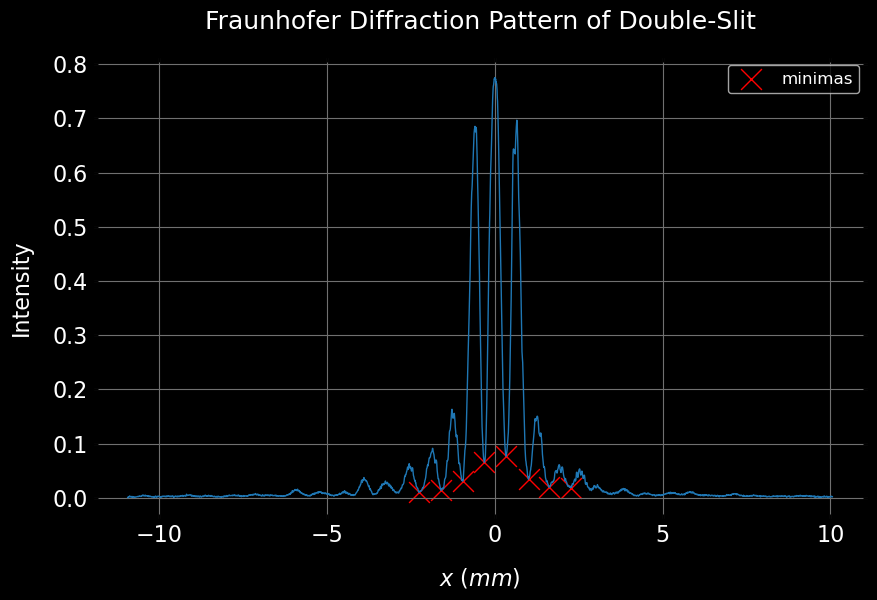

<IPython.core.display.Latex object>

In [8]:
file_path = data_dir + 'Task2_abc/DS_Fr_469_84_A.csv'

df = pd.read_csv(file_path, names=['x', 'I'])

x = np.array(df['x'], dtype=int)*pw # m
I = np.array(df['I'])
x = x - x[I.argmax()] # shift x to the max intensity

minima_indices, _ = find_peaks(-I, height=-0.1, distance=10, prominence=0.032)
plt.plot(x*1e3, I)
plt.scatter(x[minima_indices]*1e3, I[minima_indices], marker='x', label = 'minimas', color = 'r')
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Fraunhofer Diffraction Pattern of Double-Slit')
plt.legend()
plt.show()
dy(Lx(r'$Figure\, 2.1$: Fraunhofer Diffraction Pattern of Double-Slit.'))

$$x_n \approx \frac{f\lambda}{2g}(2n + 1)$$

$$ k \equiv \frac{f\lambda}{2g}$$

$$g = \frac{f\lambda}{2k}$$

$$\mu_g = \left|\frac{\partial g}{\partial k}\right|\mu_k = \left|-\frac{g}{k}\right|\mu_k$$

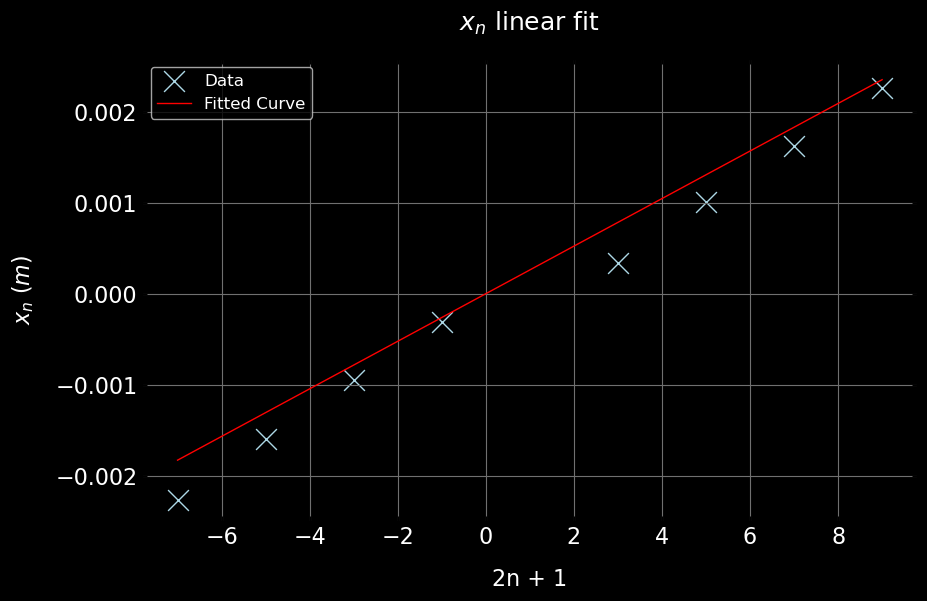

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
x_mins = x[minima_indices]
n = np.array(range(1, len(x_mins)//2+1))
n = np.sort(np.concatenate((-n, n))) # ordered symmetric list of orders e.g.: -3, -2, -1, 1, 2, 3

k, u_k_squared = fit_and_plot(2*n+1, x_mins, '2n + 1', r'$x_n$ ($m$)', '$x_n$ linear fit',  y_x)
dy(Lx(r'$Figure\, 2.2$: Linear fit of position with respect to minimum diffraction order.'))
ds_g_from_position = f*Lambda / k/2 # double-slit g from position of minima
u_ds_g_from_position = ds_g_from_position / k * np.sqrt(u_k_squared)
dy(Lx(r'$$g = (%.2f \pm %.3f) ~mm $$' % (ds_g_from_position*1e3,u_ds_g_from_position*1e3)))

### Task2 b

$$k_x = \frac{2\pi}{\lambda}\frac{x}{\sqrt{x^2 + f^2}}$$

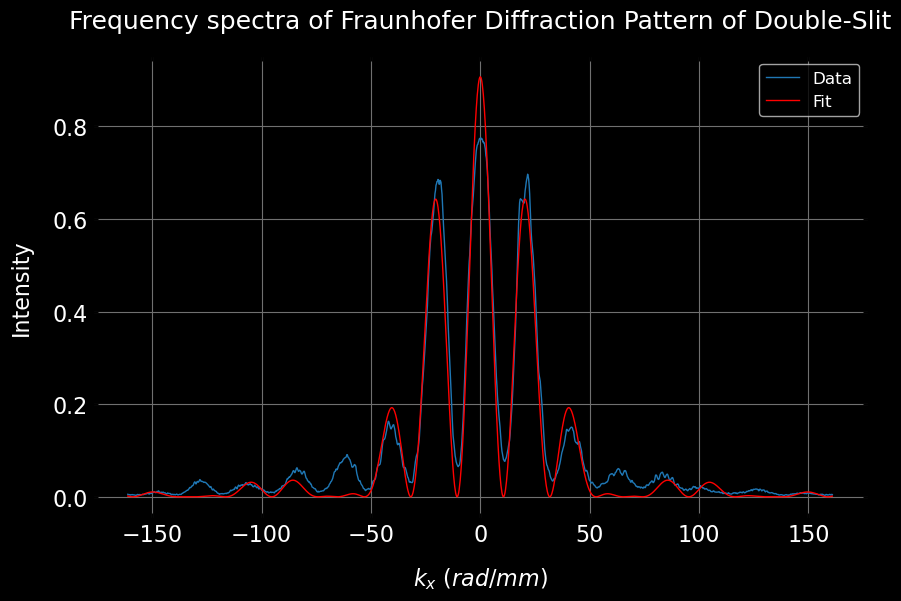

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
k = 2*np.pi / Lambda * x / np.sqrt(x**2 + f**2)
#k = 2*np.pi / Lambda * x / f
I_0 = I.max()
def ds_intensity(k_arg, b_arg, g_arg, A):
    eps = 1e-150
    return A*np.sinc(b_arg*k_arg/2 + eps)**2 * np.cos(g_arg*k_arg/2)**2

ds_fit = curve_fit(ds_intensity,k,I,p0=(1e-4,1e-4,1e-1))
offset_ind = 700
mid_ind = I.argmax()
plt.plot(k[mid_ind-offset_ind:mid_ind+offset_ind]*1e-3, I[mid_ind-offset_ind:mid_ind+offset_ind], label='Data')
plt.plot(k[mid_ind-offset_ind:mid_ind+offset_ind]*1e-3, ds_intensity(k, ds_fit[0][0],ds_fit[0][1],ds_fit[0][2])[mid_ind-offset_ind:mid_ind+offset_ind], label='Fit', color='r')
plt.xlabel(r'$k_x$ ($rad/mm$)')
plt.ylabel(r'Intensity')
plt.grid(True)
plt.title(r'Frequency spectra of Fraunhofer Diffraction Pattern of Double-Slit')
plt.legend()
plt.show()
dy(Lx(r'$Figure\, 2.3$: Frequency spectra of Fraunhofer Diffraction Pattern of Double-Slit.'))
ds_b_from_fit = ds_fit[0][0]
ds_g_from_fit = ds_fit[0][1]
u_ds_b_from_fit = np.sqrt(ds_fit[1][0][0])
u_ds_g_from_fit = np.sqrt(ds_fit[1][1][1])
dy(Lx(r'$$b = (%.2f \pm %.3f) ~\mu m = %.2f ~mm$$' % (ds_b_from_fit*1e6,u_ds_b_from_fit*1e6,ds_b_from_fit*1e3)))
dy(Lx(r'$$g = (%.2f \pm %.3f) ~\mu m = %.2f ~mm$$' % (ds_g_from_fit*1e6,u_ds_g_from_fit*1e6,ds_g_from_fit*1e3)))

### Task2 c

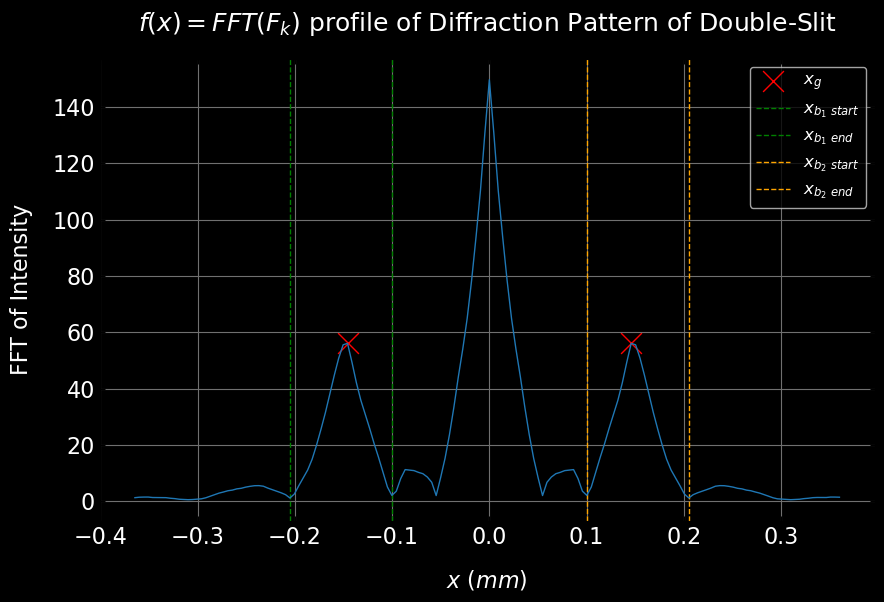

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [11]:
#F_k_fft = np.fft.ifft(I)
#F_th = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(1.2*np.sinc(k*ss_b_from_position/np.pi)**2)))
F_k_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(I)))
freq = np.fft.fftshift(np.fft.fftfreq(len(k), d=np.gradient(k)/np.pi))
#plt.plot(freq*1e3, np.abs(F_k_fft))
F_k = np.abs(F_k_fft)
mid_ind = F_k.argmax()
offset_ind = 30
left_F_k = F_k[mid_ind-2*offset_ind:mid_ind-offset_ind]
right_F_k = F_k[mid_ind+offset_ind:mid_ind+2*offset_ind]
left_peaks, _ = find_peaks(left_F_k, height=40)
left_peak = left_peaks[0] + mid_ind - 2*offset_ind
right_peaks, _ = find_peaks(right_F_k, height=40)
right_peak = right_peaks[0] + mid_ind + offset_ind
g_ind = [left_peak, right_peak]

offset_ind = 20
mid_ind = left_peak
tmp_F_k = F_k[mid_ind-offset_ind:mid_ind+offset_ind]
left_peaks, _ = find_peaks(-tmp_F_k, height=-10)
b_left = left_peaks + mid_ind-offset_ind

mid_ind = right_peak
tmp_F_k = F_k[mid_ind-offset_ind:mid_ind+offset_ind]
right_peaks, _ = find_peaks(-tmp_F_k, height=-10)
b_right = right_peaks + mid_ind-offset_ind

left_base_start = b_left[0]
left_base_end = b_left[-1]
right_base_start = b_right[0]
right_base_end = b_right[-1]


plt.scatter(freq[g_ind]*1e3,F_k[g_ind], color='r', marker='x', label=r'$x_g$')
plt.axvline(freq[left_base_start]*1e3, color='g', linestyle='--', label=r'$x_{b_1~start}$')
plt.axvline(freq[left_base_end]*1e3, color='g', linestyle='--', label=r'$x_{b_1~end}$')
plt.axvline(freq[right_base_start]*1e3, color='orange', linestyle='--', label=r'$x_{b_2~start}$')
plt.axvline(freq[right_base_end]*1e3, color='orange', linestyle='--', label=r'$x_{b_2~end}$')
plt.plot(freq[len(freq)//2-80:len(freq)//2+80]*1e3, F_k[len(freq)//2-80:len(freq)//2+80])
plt.xlabel(r'$x$ ($mm$)')
plt.ylabel(r'FFT of Intensity')
plt.grid(True)
plt.legend()
plt.title(r'$f(x) = FFT(F_k)$ profile of Diffraction Pattern of Double-Slit')
plt.show()
dy(Lx(r'$Figure\, 2.4$: Fourier transformed profile of intensity of Double-Slit.'))
ds_b_from_fft = 0.25*(freq[left_base_end] - freq[left_base_start] + freq[right_base_end] - freq[right_base_start])
dy(Lx(r'$$b = \frac{1}{2}\left(\frac{x_{1_{base~end}} - x_{1_{base~start}}}{2} + \frac{x_{2_{base~end}} - x_{2_{base~start}}}{2} \right) \approx %.2f ~mm $$' % (ds_b_from_fft*1e3)))
ds_g_from_fft = freq[g_ind[1]] - freq[g_ind[0]]
dy(Lx(r'$$g = x_{g_2} - x_{g_1} \approx %.2f ~mm $$' % (ds_g_from_fft*1e3)))

### Task2 d

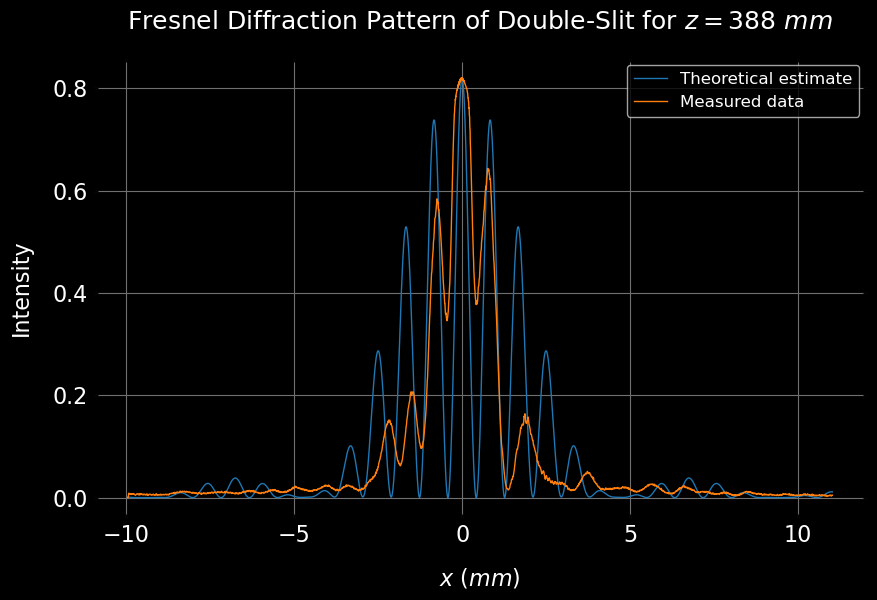

<IPython.core.display.Latex object>

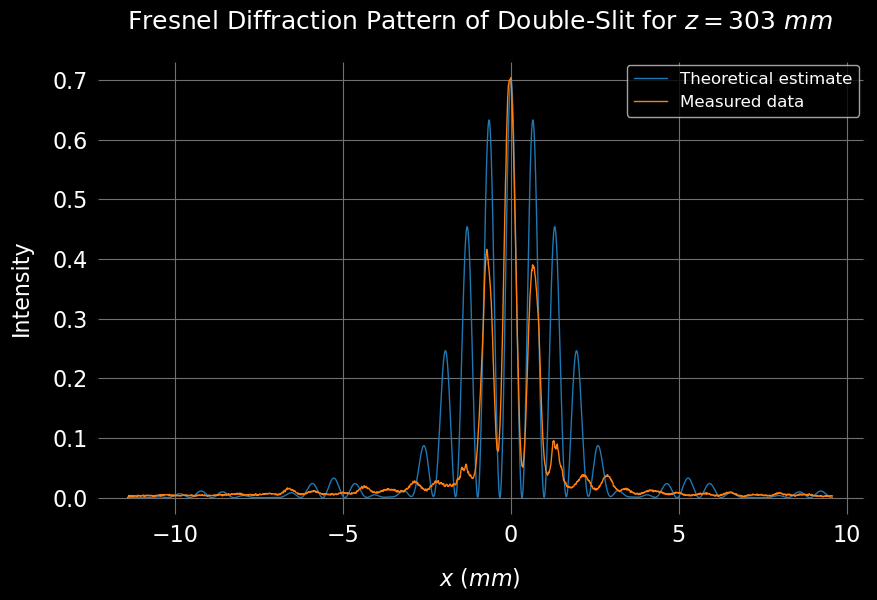

<IPython.core.display.Latex object>

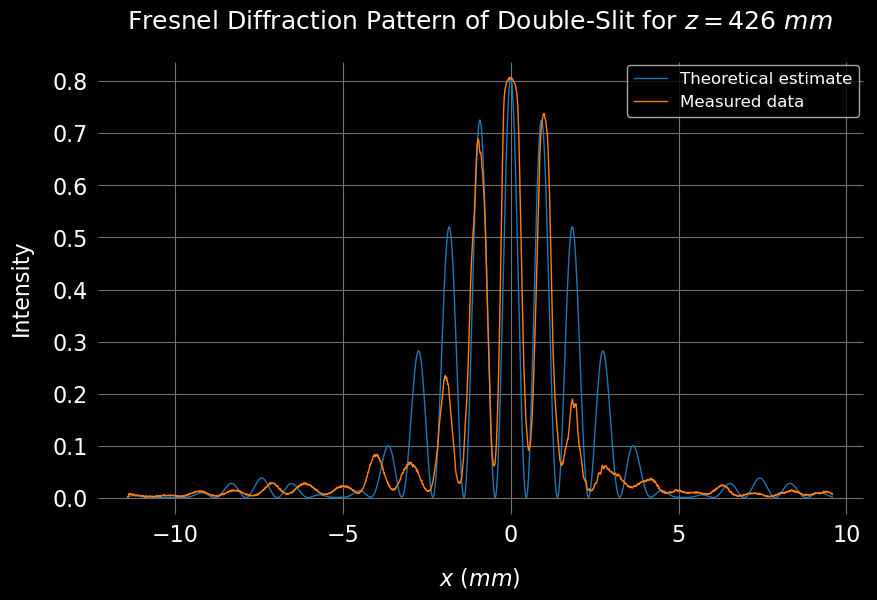

<IPython.core.display.Latex object>

In [12]:
task_dir = data_dir + 'Task2_d'
df_l = []
for path in os.listdir(task_dir):
    file_path = os.path.join(task_dir,path)
    if os.path.isfile(file_path): 
        df = pd.read_csv(file_path, names=['x', 'I'])
        x = np.array(df['x']) * pw 
        I = np.array(df['I'])
        x = x - x[I.argmax()]
        df_l.append(tuple([x,I]))
        
for i,d in enumerate(df_l):
    u_left_plus = (ds_g_from_fft - ds_b_from_fft + 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_left_minus = (ds_g_from_fft - ds_b_from_fft - 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_right_plus = (ds_g_from_fft + ds_b_from_fft + 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    u_right_minus = (ds_g_from_fft + ds_b_from_fft - 2*d[0])/np.sqrt(2*Lambda*z_l[i])
    C_left_plus, S_left_plus = fresnel(u_left_plus)
    C_right_plus, S_right_plus = fresnel(u_right_plus)
    C_left_minus, S_left_minus = fresnel(u_left_minus)
    C_right_minus, S_right_minus = fresnel(u_right_minus)
    I_th = 0.5*((C_right_plus+C_right_minus-C_left_plus-C_left_minus)**2 + (S_right_plus+S_right_minus-S_left_plus-S_left_minus)**2)
    scaling_factor = d[1].max()/I_th.max()
    I_th = I_th*scaling_factor
    ss_total = np.sum((d[1] - np.mean(d[1])) ** 2)
    ss_residual = np.sum((d[1] - I_th) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    plt.plot(d[0]*1e3,I_th, label=r'Theoretical estimate')
    plt.plot(d[0]*1e3, d[1], label=r'Measured data')
    plt.title(r'Fresnel Diffraction Pattern of Double-Slit for $z = %d ~mm$' % (z_l[i]*1e3))
    plt.grid(True)
    plt.legend()
    plt.xlabel(r'$x$ ($mm$)')
    plt.ylabel(r'Intensity')
    plt.show()
    dy(Lx(r"$Figure\, 2.%d$: Fresnel Diffraction Pattern of Double-Slit ($z = %d ~mm$). $R^2 = %.2f $" % (5 + i, z_l[i]*1e3, r_squared)))
    

***References***

1) [O17e Lab instruction](https://moodle2.uni-leipzig.de/pluginfile.php/3683853/mod_resource/content/1/O17e_2024.pdf)
